# NECCESARY LIBARIES

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import unicodedata
import torch.optim as optim
from tqdm import tqdm



In [38]:
import wandb
wandb.login(key="594642013968a68e466138e783dcece6765c43b9")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# PATH

In [39]:
train_path = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv'
valid_path = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv'
test_path  = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv'


 # Attention class

In [40]:

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        nn.init.xavier_uniform_(self.attn.weight)
        self.v.data.normal_(mean=0, std=0.01)

    def forward(self, hidden, encoder_outputs):
        # hidden: [num_layers, batch_size, hidden_size] (decoder's last hidden state)
        # encoder_outputs: [batch_size, src_len, hidden_size]
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Use the last layer's hidden state for attention
        hidden = hidden[-1]  # [batch_size, hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, hidden_size]

        # Compute attention scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_size]
        energy = energy.transpose(1, 2)  # [batch_size, hidden_size, src_len]
        v = self.v.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, hidden_size]
        attention_scores = torch.bmm(v, energy).squeeze(1)  # [batch_size, src_len]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, src_len]

        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_size]
        return  context,attention_weights

# Encoder ,decoder, seq2seq class

In [41]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers=1, cell_type='LSTM', dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.embedding = nn.Embedding(input_size, embedding_dim)
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_class(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))
        batch_size = input_seq.size(0)
        device = input_seq.device
        if self.cell_type == 'LSTM':
            hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                      torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_size, num_layers=1, cell_type='LSTM', dropout=0.2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.attention = Attention(hidden_size)
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_class(
            input_size=embedding_dim + hidden_size,  # Input includes context vector
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.out = nn.Linear(hidden_size * 2, output_size)  # Combine RNN output and context
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input_char, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, embedding_dim]
        context, attention_weights = self.attention(hidden[0] if self.cell_type == 'LSTM' else hidden, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, embedding_dim + hidden_size]
        output, hidden = self.rnn(rnn_input, hidden)
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)  # [batch_size, hidden_size * 2]
        output = self.softmax(self.out(output))
        return output, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.embedding.num_embeddings
        device = source.device
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        encoder_outputs, hidden = self.encoder(source)
        if self.encoder.num_layers != self.decoder.num_layers:
            if self.encoder.cell_type == 'LSTM':
                h_n, c_n = hidden
                if self.decoder.num_layers > self.encoder.num_layers:
                    extra_layers = self.decoder.num_layers - self.encoder.num_layers
                    extra_h = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    extra_c = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    h_n = torch.cat([h_n, extra_h], dim=0)
                    c_n = torch.cat([c_n, extra_c], dim=0)
                else:
                    h_n = h_n[:self.decoder.num_layers]
                    c_n = c_n[:self.decoder.num_layers]
                hidden = (h_n, c_n)
            else:
                if self.decoder.num_layers > self.encoder.num_layers:
                    extra_layers = self.decoder.num_layers - self.encoder.num_layers
                    extra_h = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    hidden = torch.cat([hidden, extra_h], dim=0)
                else:
                    hidden = hidden[:self.decoder.num_layers]
        decoder_input = target[:, 0].unsqueeze(1)
        for t in range(1, target_len):
            output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            decoder_input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)
        return outputs

    def predict(self, src, max_len=30, beam_size=3):
        self.eval()
        batch_size = src.size(0)
        device = src.device
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        for i in range(batch_size):
            if self.encoder.cell_type == 'LSTM':
                h = hidden[0][:, i:i+1].contiguous()
                c = hidden[1][:, i:i+1].contiguous()
                hidden_state = (h, c)
            else:
                hidden_state = hidden[:, i:i+1].contiguous()
            if self.encoder.num_layers != self.decoder.num_layers:
                if self.encoder.cell_type == 'LSTM':
                    h_n, c_n = hidden_state
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        extra_c = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        h_n = torch.cat([h_n, extra_h], dim=0)
                        c_n = torch.cat([c_n, extra_c], dim=0)
                    else:
                        h_n = h_n[:self.decoder.num_layers]
                        c_n = c_n[:self.decoder.num_layers]
                    hidden_state = (h_n, c_n)
                else:
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        hidden_state = torch.cat([hidden_state, extra_h], dim=0)
                    else:
                        hidden_state = hidden_state[:self.decoder.num_layers]
            beams = [(torch.tensor([1], device=device), 0.0, hidden_state, [])]  # [sequence, score, hidden, attention_weights]
            for _ in range(max_len):
                new_beams = []
                for seq, score, h, attn_weights in beams:
                    input_char = seq[-1].unsqueeze(0).unsqueeze(0)
                    output, h_new, attn_w = self.decoder(input_char, h, encoder_outputs[i:i+1])  # Fix: Use [i:i+1] instead of [:, i:i+1]
                    probs = torch.log_softmax(output, dim=-1).squeeze(0)
                    topk = torch.topk(probs, beam_size)
                    for idx, prob in zip(topk.indices, topk.values):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + prob.item()
                        new_attn_weights = attn_weights + [attn_w]
                        if self.decoder.cell_type == 'LSTM':
                            h_new = (h_new[0].contiguous(), h_new[1].contiguous())
                        else:
                            h_new = h_new.contiguous()
                        new_beams.append((new_seq, new_score, h_new, new_attn_weights))
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
                if beams[0][0][-1].item() == 2:  # Stop if <EOS>
                    break
            outputs.append(beams[0][0][1:])  # Exclude <SOS>
        return outputs

    def predict_with_attention(self, src, max_len=30, beam_size=3):
        self.eval()
        batch_size = src.size(0)
        device = src.device
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        all_attn_weights = []
        for i in range(batch_size):
            if self.encoder.cell_type == 'LSTM':
                h = hidden[0][:, i:i+1].contiguous()
                c = hidden[1][:, i:i+1].contiguous()
                hidden_state = (h, c)
            else:
                hidden_state = hidden[:, i:i+1].contiguous()
            if self.encoder.num_layers != self.decoder.num_layers:
                if self.encoder.cell_type == 'LSTM':
                    h_n, c_n = hidden_state
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        extra_c = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        h_n = torch.cat([h_n, extra_h], dim=0)
                        c_n = torch.cat([c_n, extra_c], dim=0)
                    else:
                        h_n = h_n[:self.decoder.num_layers]
                        c_n = c_n[:self.decoder.num_layers]
                    hidden_state = (h_n, c_n)
                else:
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        hidden_state = torch.cat([hidden_state, extra_h], dim=0)
                    else:
                        hidden_state = hidden_state[:self.decoder.num_layers]
            beams = [(torch.tensor([1], device=device), 0.0, hidden_state, [])]  # [sequence, score, hidden, attention_weights]
            for _ in range(max_len):
                new_beams = []
                for seq, score, h, attn_weights in beams:
                    input_char = seq[-1].unsqueeze(0).unsqueeze(0)
                    output, h_new, attn_w = self.decoder(input_char, h, encoder_outputs[i:i+1])
                    probs = torch.log_softmax(output, dim=-1).squeeze(0)
                    topk = torch.topk(probs, beam_size)
                    for idx, prob in zip(topk.indices, topk.values):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + prob.item()
                        new_attn_weights = attn_weights + [attn_w]
                        if self.decoder.cell_type == 'LSTM':
                            h_new = (h_new[0].contiguous(), h_new[1].contiguous())
                        else:
                            h_new = h_new.contiguous()
                        new_beams.append((new_seq, new_score, h_new, new_attn_weights))
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
                if beams[0][0][-1].item() == 2:  # Stop if <EOS>
                    break
            outputs.append(beams[0][0][1:])  # Exclude <SOS>
            all_attn_weights.append(beams[0][3])  # Store attention weights
        return outputs, all_attn_weights






# TRAINER CLASS

In [ ]:

class Trainer:
    def __init__(self, model, train_loader, val_loader, config, device='cpu', save_path='best_model.pt'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config
        self.teacher_forcing_ratio = config.teacher_forcing
        self.num_epochs = config.epochs
        self.save_path = save_path
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)  # Changed to CrossEntropyLoss
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)
        self.src_vocab = None  # To store vocab for predictions
        self.tgt_vocab = None

    def compute_token_accuracy(self, outputs, targets):
        """Compute token-level accuracy."""
        outputs = outputs.argmax(dim=-1)  # [batch_size, seq_len]
        non_pad_mask = (targets != 0) & (targets != 1) & (targets != 2)  # Exclude <PAD>, <SOS>, <EOS>
        correct = (outputs == targets) & non_pad_mask
        total = non_pad_mask.sum().item()
        correct = correct.sum().item()
        return correct / total if total > 0 else 0.0

    def compute_sequence_accuracy(self, outputs, targets):
        """Compute sequence-level accuracy."""
        outputs = outputs.argmax(dim=-1)  # [batch_size, seq_len]
        correct = 0
        total = outputs.size(0)
        for pred, tgt in zip(outputs, targets):
            # Compare sequences, ignoring <PAD>, <SOS>, <EOS>
            pred = pred[(tgt != 0) & (tgt != 1) & (tgt != 2)]
            tgt = tgt[(tgt != 0) & (tgt != 1) & (tgt != 2)]
            if torch.equal(pred, tgt):
                correct += 1
        return correct / total if total > 0 else 0.0

    def train_epoch(self):
        self.model.train()
        total_loss, total_token_acc, total_seq_acc, total_samples = 0.0, 0.0, 0.0, 0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for src, tgt, _, _ in pbar:  # Adjusted for src_strs, tgt_strs from DataLoader
            src, tgt = src.to(self.device), tgt.to(self.device)
            self.optimizer.zero_grad()

            output = self.model(src, tgt, self.teacher_forcing_ratio)
            output = output[:, 1:].contiguous().view(-1, output.size(-1))
            tgt_flat = tgt[:, 1:].contiguous().view(-1)

            loss = self.criterion(output, tgt_flat)
            loss.backward()
            self.optimizer.step()

            batch_size = src.size(0)
            token_acc = self.compute_token_accuracy(
                output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
            )
            seq_acc = self.compute_sequence_accuracy(
                output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
            )

            total_loss += loss.item() * batch_size
            total_token_acc += token_acc * batch_size
            total_seq_acc += seq_acc * batch_size
            total_samples += batch_size

            pbar.set_postfix(loss=loss.item(), token_acc=token_acc, seq_acc=seq_acc)

        avg_loss = total_loss / total_samples
        avg_token_acc = total_token_acc / total_samples
        avg_seq_acc = total_seq_acc / total_samples
        return avg_loss, avg_token_acc, avg_seq_acc

    def evaluate(self, loader):
        self.model.eval()
        total_loss, total_token_acc, total_seq_acc, total_samples = 0.0, 0.0, 0.0, 0

        pbar = tqdm(loader, desc="Evaluating", leave=False)
        with torch.no_grad():
            for src, tgt, _, _ in pbar:
                src, tgt = src.to(self.device), tgt.to(self.device)

                output = self.model(src, tgt, teacher_forcing_ratio=0.0)
                output = output[:, 1:].contiguous().view(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].contiguous().view(-1)

                loss = self.criterion(output, tgt_flat)

                batch_size = src.size(0)
                token_acc = self.compute_token_accuracy(
                    output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
                )
                seq_acc = self.compute_sequence_accuracy(
                    output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
                )

                total_loss += loss.item() * batch_size
                total_token_acc += token_acc * batch_size
                total_seq_acc += seq_acc * batch_size
                total_samples += batch_size

                pbar.set_postfix(loss=loss.item(), token_acc=token_acc, seq_acc=seq_acc)

        avg_loss = total_loss / total_samples
        avg_token_acc = total_token_acc / total_samples
        avg_seq_acc = total_seq_acc / total_samples
        return avg_loss, avg_token_acc, avg_seq_acc

    def train(self, src_vocab, tgt_vocab):
        """Train the model, logging metrics and predictions to Wandb."""
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        best_val_seq_acc = 0.0
        patience = getattr(self.config, 'patience', 3)
        patience_counter = 0

        for epoch in range(1, self.num_epochs + 1):
            # Train
            train_loss, train_token_acc, train_seq_acc = self.train_epoch()
            # Evaluate
            val_loss, val_token_acc, val_seq_acc = self.evaluate(self.val_loader)

            # Print metrics
            print(f'\nEpoch {epoch}/{self.num_epochs}')
            print(f'Train Loss: {train_loss:.4f} | Train Token Acc: {train_token_acc*100:.2f}% | Train Seq Acc: {train_seq_acc*100:.2f}%')
            print(f'Val Loss:   {val_loss:.4f} | Val Token Acc:   {val_token_acc*100:.2f}% | Val Seq Acc:   {val_seq_acc*100:.2f}%')
            print('-' * 60)

            # Log metrics to Wandb
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                 'val_loss': val_loss,

                'train_token_accuracy': train_token_acc,
                'val_token_accuracy': val_token_acc,
                'train_sequence_accuracy': train_seq_acc,
                               
                'val_sequence_accuracy': val_seq_acc
            })

            # Log sample predictions
            src_sample, tgt_sample, src_strs, tgt_strs = next(iter(self.val_loader))
            src_sample = src_sample.to(self.device)
            preds = self.model.predict(src_sample[:5], max_len=30, beam_size=self.config.beam_size)

            inv_src_vocab = {v: k for k, v in src_vocab.items()}
            inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}
            table = wandb.Table(columns=["Input", "Target", "Prediction"])
            for i in range(len(preds)):
                input_str = ''.join([inv_src_vocab.get(id.item(), '?') for id in src_sample[i] if id.item() not in [0, src_vocab['<EOS>']]])
                target_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in tgt_sample[i] if id.item() not in [0, tgt_vocab['<EOS>'], tgt_vocab['<SOS>']]])
                pred_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in preds[i] if id.item() not in [0, tgt_vocab['<EOS>']]])
                table.add_data(input_str, target_str, pred_str)
            wandb.log({"predictions": table})

            # Early stopping and checkpoint
            if val_seq_acc > best_val_seq_acc:
                best_val_seq_acc = val_seq_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), self.save_path)
                print(f"✅ New best model saved with val sequence accuracy: {val_seq_acc*100:.2f}%")
            else:
                patience_counter += 1
                print(f"⚠️ No improvement. Patience counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("🛑 Early stopping triggered.")
                    break


# Class data preprocessing

In [ ]:
class DataPreprocessor:
    def __init__(self, batch_size=32, device='cpu'):
        self.batch_size = batch_size
        self.device = device
        self.src_vocab = None
        self.tgt_vocab = None
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'
        self.UNK_TOKEN = '<UNK>'
        self.PAD_IDX = 0
        self.SOS_IDX = 1
        self.EOS_IDX = 2
        self.UNK_IDX = 3

    def normalize_string(self, s):
        s = unicodedata.normalize('NFC', str(s))
        if all(ord(c) < 128 for c in s):
            s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
            s = s.lower()
        return s.strip()

    def load_dataset(self, file_path=None, data_frame=None):
        if file_path:
            try:
                data = pd.read_csv(file_path, sep='\t', header=None)
            except:
                data = pd.read_csv(file_path, header=None)
        elif data_frame is not None:
            data = data_frame.copy()
        else:
            raise ValueError("Either file_path or data_frame must be provided.")
        data = data.rename(columns={0: 'tgt', 1: 'src'})
        data['src'] = data['src'].apply(self.normalize_string)
        data['tgt'] = data['tgt'].apply(self.normalize_string)
        return data

    def create_vocab(self, data, column):
        vocab = {self.PAD_TOKEN: self.PAD_IDX, self.SOS_TOKEN: self.SOS_IDX,
                 self.EOS_TOKEN: self.EOS_IDX, self.UNK_TOKEN: self.UNK_IDX}
        for seq in data[column]:
            if pd.notna(seq):
                for char in seq:
                    if char not in vocab:
                        vocab[char] = len(vocab)
        return vocab

    def build_vocabularies(self, train_data):
        self.src_vocab = self.create_vocab(train_data, 'src')
        self.tgt_vocab = self.create_vocab(train_data, 'tgt')
        return self.src_vocab, self.tgt_vocab

    class TranslationDataset(Dataset):
        def __init__(self, data, input_vocab, output_vocab):
            self.data = data
            self.input_vocab = input_vocab
            self.output_vocab = output_vocab

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            src = [self.input_vocab.get(c, self.input_vocab['<UNK>']) for c in self.data.iloc[idx, 1]] + [self.input_vocab['<EOS>']]
            tgt = [self.output_vocab['<SOS>']] + [self.output_vocab.get(c, self.output_vocab['<UNK>']) for c in self.data.iloc[idx, 0]] + [self.output_vocab['<EOS>']]
            src_str = self.data.iloc[idx, 1]
            tgt_str = self.data.iloc[idx, 0]
            return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long), src_str, tgt_str

    def pad_collate(self, batch):
        src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)
        src_padded = pad_sequence(src_batch, batch_first=True, padding_value=self.PAD_IDX)
        tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=self.PAD_IDX)
        return src_padded, tgt_padded, list(src_strs), list(tgt_strs)

    def prepare_data(self, train_data, val_data, test_data):
        if self.src_vocab is None or self.tgt_vocab is None:
            self.build_vocabularies(train_data)
        train_dataset = self.TranslationDataset(train_data, self.src_vocab, self.tgt_vocab)
        val_dataset = self.TranslationDataset(val_data, self.src_vocab, self.tgt_vocab)
        test_dataset = self.TranslationDataset(test_data, self.src_vocab, self.tgt_vocab)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,
                                 collate_fn=self.pad_collate, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False,
                                collate_fn=self.pad_collate, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False,
                                 collate_fn=self.pad_collate, pin_memory=True)
        return train_loader, val_loader, test_loader
import torch

# train loader function 

In [ ]:
def train_loader(
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    valid_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv',
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='/kaggle/working/best_model.pt'
):
    """
    Training function for running a WandB sweep on the Bengali Dakshina dataset with attention-based Seq2Seq.
    """
    # Initialize WandB
    wandb.init(project="assignment_3")
    config = wandb.config

    # Construct a descriptive run name
    run_name = (
        f"attn-cell-{config.cell_type}"
        f"-embed-{config.emb_dim}"
        f"-enc_layers-{config.enc_layers}"
        f"-dec_layers-{config.dec_layers}"
        f"-hid-{config.hidden_dim}"
        f"-dropout-{config.dropout}"
        f"-bs-{config.batch_size}"
        f"-lr-{config.learning_rate}"
        f"-tf-{config.teacher_forcing}"
        f"-beam-{config.beam_size}"
    )
    wandb.run.name = run_name

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=config.batch_size, device=device)

    # Load datasets
    train_data = preprocessor.load_dataset(train_path)
    val_data = preprocessor.load_dataset(valid_path)
    test_data = preprocessor.load_dataset(test_path)

    # Prepare data loaders
    train_loader, val_loader, test_loader = preprocessor.prepare_data(train_data, val_data, test_data)

    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=config.emb_dim,
        hidden_size=config.hidden_dim,
        num_layers=config.enc_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=config.emb_dim,
        hidden_size=config.hidden_dim,
        num_layers=config.dec_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device,
        save_path=save_path
    )

    # Train with vocabularies
    trainer.train(preprocessor.src_vocab, preprocessor.tgt_vocab)

   

    #Finish Wandb run
    wandb.finish()



# sweep config

In [ ]:
# Wandb sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_sequence_accuracy', 'goal': 'maximize'},
    'parameters': {
        'emb_dim': {'values': [64, 128, 256]},
        'hidden_dim': {'values': [128, 256]},
        'enc_layers': {'values': [1, 2, 3]},
        'dec_layers': {'values': [1, 2, 3]},
        'cell_type': {'values': ['LSTM', 'GRU', 'RNN']},
        'dropout': {'values': [0.2, 0.3, 0.4]},
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'teacher_forcing': {'values': [0.5, 0.7, 0.9]},
        'beam_size': {'values': [1, 3, 5]},
        'patience': {'value': 3},
        'epochs': {'values': [10,15]}
    }
}


# run this code for hyperparameter tuning with the previous sweep

In [ ]:
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="assignment_3")
    wandb.agent(sweep_id, function=train_loader, count=10)

# Best hyperparamter

# batch_size:
#     value: 128
# beam_size:
#     value: 1
# cell_type:
#     value: LSTM
# dec_layers:
#     value: 3
# dropout:
#     value: 0.4
# emb_dim:
#     value: 64
# enc_layers:
#     value: 2
# epochs:
#     value: 15
# hidden_dim:
#     value: 256
# learning_rate:
#     value: 0.0005
# patience:
#     value: 3
# teacher_forcing:
#     value: 0.9

# After hyper parameter tuning train again with this hyperparameter

In [ ]:
# Wandb sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_sequence_accuracy', 'goal': 'maximize'},
    'parameters': {
        'emb_dim': {'values': [ 64]},
        'hidden_dim': {'values': [256]},
        'enc_layers': {'values': [ 2]},
        'dec_layers': {'values': [3]},
        'cell_type': {'values': ['LSTM']},
        'dropout': {'values': [ 0.4]},
        'batch_size': {'values': [ 128]},
        'learning_rate': {'values': [0.0005]},
        'teacher_forcing': {'values': [0.9]},
        'beam_size': {'values': [ 3]},
        'patience': {'value': 3},
        'epochs': {'values': [15]}
    }
}


# Run this code for the best hyperparmeter sweep , we train again and use this model for test 

In [ ]:
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="assignment_3")
    wandb.agent(sweep_id, function=train_loader, count=1)

# function for heat map and highlight the csv

In [74]:
def highlight_correct(row):
    return ['background-color: lightgreen' if row['Predicted (Bengali)'] == row['Ground Truth (Bengali)'] else 'background-color: pink'] * 3

def decode_indices(indices, index_to_token, ignore_tokens):
    """Decode indices into tokens, ignoring specified tokens."""
    valid_indices = [index.item() for index in indices if index.item() not in ignore_tokens]
    return ''.join([index_to_token.get(index, '?') for index in valid_indices])

def plot_attention(ax, input_text, output_text, attention_weights, font_properties):
    """Plot attention weights using seaborn's heatmap with Bengali font support."""
    import seaborn as sns
    # Ensure attention_weights is 2D [tgt_len, src_len]
    if attention_weights.dim() == 1:
        attention_weights = attention_weights.unsqueeze(1)
    elif attention_weights.dim() > 2:
        attention_weights = attention_weights.squeeze()
        if attention_weights.dim() == 1:
            attention_weights = attention_weights.unsqueeze(1)
        elif attention_weights.dim() > 2:
            raise ValueError(f"Attention weights have invalid shape: {attention_weights.shape}")
    
    attention_weights = attention_weights.cpu().numpy()
    
    sns.heatmap(
        attention_weights,
        xticklabels=output_text,
        yticklabels=input_text,
        ax=ax,
        cmap='viridis',
        cbar=True,
        cbar_kws={'label': 'Attention Weight'},
        square=False,
        annot=False,
        fmt='.2f'
    )
    ax.set_xticklabels(output_text, fontproperties=font_properties, rotation=45, ha='right')
    ax.set_yticklabels(input_text, fontproperties=font_properties, rotation=0)
    ax.set_xlabel('Output Sequence (Bengali)', fontsize=8)
    ax.set_ylabel('Input Sequence (Latin)', fontsize=8)
    ax.set_title(f'Input: {input_text}\nPredicted: {output_text}', fontproperties=font_properties, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)


# test model function

In [75]:
def test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',
    heatmap_output='/kaggle/working/attention_heatmaps.png',
    src_vocab_path=None,
    tgt_vocab_path=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=256,
    enc_layers=3,
    dec_layers=2,
    cell_type='GRU',
    dropout=0.2,
    beam_size=3,
    batch_size=64
):
    """
    Test the trained attention-based Seq2Seq model on the test dataset, display sample predictions,
    generate predictions for the entire test set, create a 3x3 grid of attention heatmaps,
    and generate an interactive attention visualization for 9 samples.
    """
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    from tqdm import tqdm
    
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
    # Load vocabularies
    if src_vocab_path and tgt_vocab_path:
        try:
            with open(src_vocab_path, 'rb') as f:
                preprocessor.src_vocab = pickle.load(f)
            with open(tgt_vocab_path, 'rb') as f:
                preprocessor.tgt_vocab = pickle.load(f)
            print("Vocabularies loaded from provided paths.")
        except Exception as e:
            print(f"Error loading vocabularies: {e}")
            print("Falling back to rebuilding vocabularies from training data.")
            train_data = preprocessor.load_dataset(train_path)
            preprocessor.build_vocabularies(train_data)
    else:
        train_data = preprocessor.load_dataset(train_path)
        preprocessor.build_vocabularies(train_data)
        print("Warning: Vocabularies rebuilt from training data. Ensure consistency with training.")
    
    # Load test dataset
    test_data = preprocessor.load_dataset(test_path)
    
    # Prepare test data loader
    _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=enc_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=dec_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Error loading model weights: {e}")
        print("Ensure hyperparameters match the trained model. Check WandB run config.")
        return
    
    model.eval()
    
    # Initialize Trainer (for evaluation)
    config = type('Config', (), {
        'beam_size': beam_size,
        'teacher_forcing': 0.,
        'epochs': 1,
        'learning_rate': 0.0005
    })()
    trainer = Trainer(
        model=model,
        train_loader=test_loader,
        val_loader=test_loader,
        config=config,
        device=device,
        save_path=model_path
    )
    
    # Evaluate on test set
    print("\nTest Set Evaluation:")
    test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
    print(f'Test Loss: {test_loss:.4f} | Test Token Acc: {test_token_acc*100:.2f}% | Test Seq Acc: {test_seq_acc*100:.2f}%')
    
    # Generate predictions for the entire test set
    all_data = []
    heatmap_data = []
    connectivity_data = []  # To store data for connectivity visualization
    inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
    inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
    # Define ignore tokens
    ignore_tokens = {
        preprocessor.src_vocab.get('<EOS>'),
        preprocessor.src_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<EOS>'),
        preprocessor.tgt_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<SOS>')
    }
    
    print("\nGenerating predictions for the entire test set...")
    for batch_idx, (src_sample, tgt_sample, src_strs, tgt_strs) in enumerate(tqdm(test_loader, desc="Predicting")):
        src_sample = src_sample.to(device)
        preds, attn_weights_list = model.predict_with_attention(src_sample, max_len=30, beam_size=beam_size)
        
        for i in range(len(preds)):
            input_str = decode_indices(src_sample[i], inv_src_vocab, ignore_tokens)
            target_str = decode_indices(tgt_sample[i], inv_tgt_vocab, ignore_tokens)
            pred_str = decode_indices(preds[i], inv_tgt_vocab, ignore_tokens)
            all_data.append([input_str, target_str, pred_str])
            
            # Collect data for heatmap (first 9 valid samples)
            if len(heatmap_data) < 9:
                try:
                    attn_weights = torch.cat([w.detach() for w in attn_weights_list[i]], dim=0)
                except Exception as e:
                    print(f"Error concatenating attention weights for sample {len(heatmap_data)+1}: {e}")
                    continue
                
                if attn_weights.dim() != 2:
                    print(f"Invalid attention weights shape for sample {len(heatmap_data)+1}: {attn_weights.shape}")
                    src_len = len([t for t in src_sample[i] if t.item() not in ignore_tokens])
                    tgt_len = len([t for t in preds[i] if t.item() not in ignore_tokens])
                    if src_len > 0 and tgt_len > 0:
                        attn_weights = torch.ones((tgt_len, src_len), device=device) / src_len
                        print(f"Using mock attention weights [{tgt_len}, {src_len}] for sample {len(heatmap_data)+1}")
                    else:
                        print(f"Skipping sample {len(heatmap_data)+1}: Invalid token lengths (src_len={src_len}, tgt_len={tgt_len})")
                        continue
                
                heatmap_data.append({
                    'src_tokens': list(input_str),
                    'tgt_tokens': list(pred_str),
                    'attn_weights': attn_weights,
                    'input_str': input_str,
                    'pred_str': pred_str
                })
            
            # Collect data for connectivity (first 9 valid samples)
            if len(connectivity_data) < 9:
                try:
                    attn_weights = torch.cat([w.detach() for w in attn_weights_list[i]], dim=0)
                except Exception as e:
                    print(f"Error concatenating attention weights for connectivity sample {len(connectivity_data)+1}: {e}")
                    continue
                
                if attn_weights.dim() != 2:
                    print(f"Invalid attention weights shape for connectivity sample {len(connectivity_data)+1}: {attn_weights.shape}")
                    continue
                
                connectivity_data.append({
                    'input_str': input_str,
                    'pred_str': pred_str,
                    'attn_weights': attn_weights
                })
    
    # Save predictions to CSV
    df = pd.DataFrame(all_data, columns=['Input (Latin)', 'Ground Truth (Bengali)', 'Predicted (Bengali)'])
    try:
        df.to_csv(output_csv, index=False)
        print(f"Predictions saved to {output_csv}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")
    
    # Display sample predictions (first 50)
    sample_df = df.head(50)
    styled_df = sample_df.style.apply(highlight_correct, axis=1)
    print("\nSample Test Set Predictions (First 50):")
    display(styled_df)
    
    # Load the Bengali font (for heatmaps)
    bengali_font_path = "/kaggle/input/notosansbengalifont/NotoSansBengali-Regular.ttf"
    try:
        bengali_font = fm.FontProperties(fname=bengali_font_path, size=10)
    except Exception as e:
        print(f"Error loading Bengali font: {e}")
        print("Falling back to default font, Bengali characters may not render correctly.")
        bengali_font = fm.FontProperties(size=10)
    
    # Generate attention heatmaps
    if heatmap_data:
        n_samples = min(9, len(heatmap_data))
        rows = min(3, (n_samples + 2) // 3)
        fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for i in range(n_samples):
            data = heatmap_data[i]
            try:
                plot_attention(axes[i], data['src_tokens'], data['tgt_tokens'], data['attn_weights'], bengali_font)
            except Exception as e:
                print(f"Error plotting heatmap for sample {i+1}: {e}")
        
        for j in range(n_samples, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        try:
            plt.savefig(heatmap_output, dpi=300, bbox_inches='tight')
            print(f"Attention heatmaps saved to {heatmap_output}")
        except Exception as e:
            print(f"Error saving heatmap: {e}")
        plt.show()
    else:
        print("No valid attention weights for heatmap generation.")
    


# for run the test model with the saved model 

Model weights loaded successfully.

Test Set Evaluation:


Test Loss: 1.5727 | Test Token Acc: 72.49% | Test Seq Acc: 40.45%

Generating predictions for the entire test set...


Predicting: 100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


Predictions saved to /kaggle/working/test_predictions.csv

Sample Test Set Predictions (First 50):


,Input (Latin),Ground Truth (Bengali),Predicted (Bengali)
0,anri,অঁরি,আনরি
1,aunry,অঁরি,অ্যান্রি
2,onry,অঁরি,অনরি
3,ori,অঁরি,অরি
4,angsagrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
5,angshogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
6,angsogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
7,anshograhankari,অংশগ্রহনকারী,অংশগ্রহণকারী
8,ongsagrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
9,ongshogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী


Attention heatmaps saved to /kaggle/working/attention_heatmaps.png


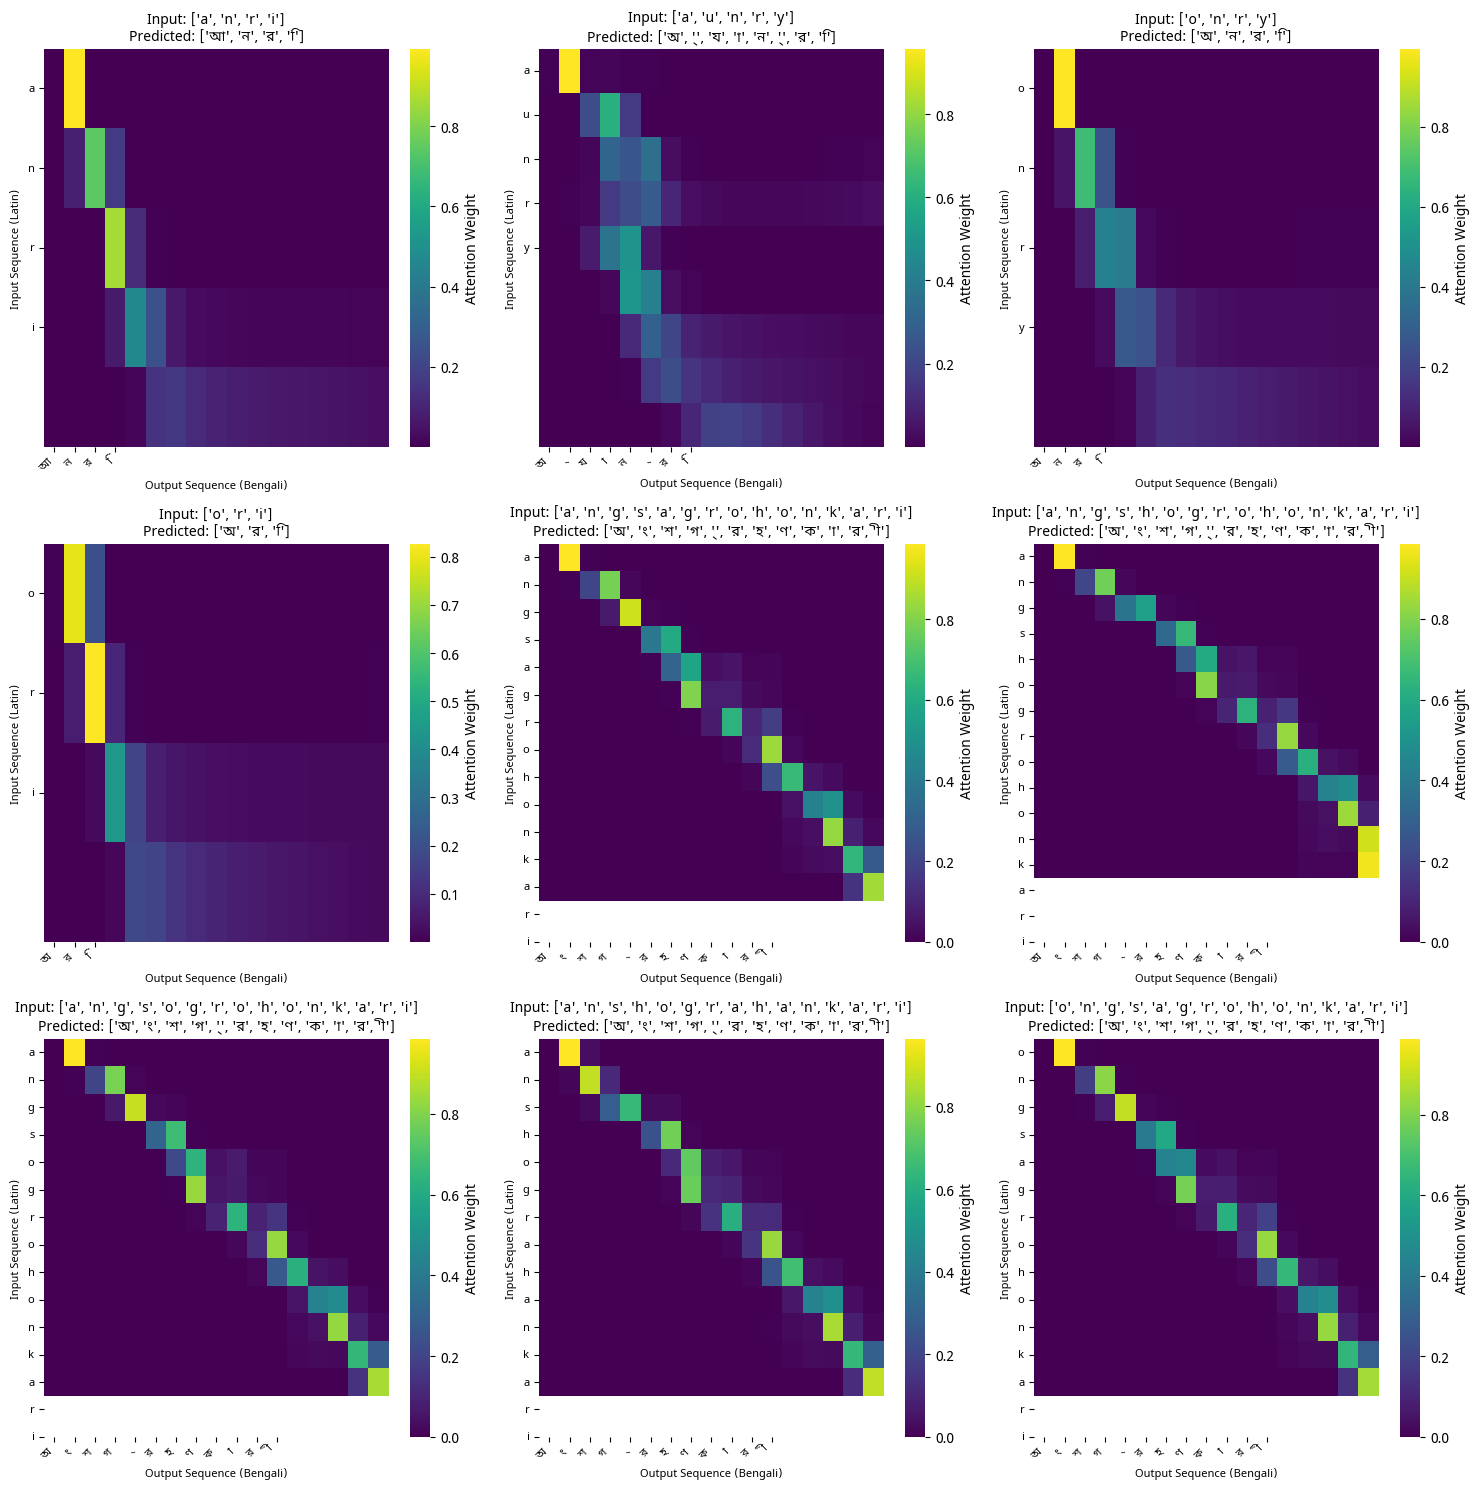

In [76]:
import matplotlib.pyplot as plt
import numpy as np
df = test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',
    heatmap_output='/kaggle/working/attention_heatmaps.png',
    src_vocab_path=None,  # Update if saved
    tgt_vocab_path=None,  # Update if saved
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=256,
    enc_layers=2,
    dec_layers=3,
    cell_type='LSTM',
    dropout=0.4,
    beam_size=1,
    batch_size=128
)

# wandb: 	batch_size: 128
# wandb: 	beam_size: 3
# wandb: 	cell_type: LSTM
# wandb: 	dec_layers: 3
# wandb: 	dropout: 0.4
# wandb: 	emb_dim: 64
# wandb: 	enc_layers: 2
# wandb: 	epochs: 15
# wandb: 	hidden_dim: 256
# wandb: 	learning_rate: 0.0005
# wandb: 	patience: 3
# wandb: 	teacher_forcing: 0.9

# A trial for visulization not as expeceted as i want 

In [66]:
def test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',  # Will not be used
    heatmap_output='/kaggle/working/attention_heatmaps.png',  # Will not be used
    attention_output='/kaggle/working/attention_animations',
    src_vocab_path=None,
    tgt_vocab_path=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=256,
    enc_layers=3,
    dec_layers=2,
    cell_type='GRU',
    dropout=0.2,
    beam_size=3,
    batch_size=64
):
    """
    Test the trained attention-based Seq2Seq model on the test dataset, create animated visualizations
    showing how attention evolves for each letter in the predicted word, and generate an interactive
    attention visualization (connectivity.html) for selected samples.
    """
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import matplotlib.animation as animation
    from tqdm import tqdm
    import wandb
    import os
    import numpy as np
    import torch

    # Initialize W&B
    wandb.init(project="assignment_3", name="test-inference-attention-animation-and-connectivity")

    # Ensure ffmpeg is available for animation saving
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
    try:
        animation.writers['ffmpeg']
        print("ffmpeg writer is available for animation.")
    except KeyError:
        print("ffmpeg writer not available. Animation saving may fail. Ensure ffmpeg is installed.")
    
    # Load and register the Bengali font globally
    bengali_font_path = "/kaggle/input/notosansbengalifont/NotoSansBengali-Regular.ttf"
    try:
        fm.fontManager.addfont(bengali_font_path)
        plt.rcParams['font.family'] = 'Noto Sans Bengali'
        plt.rcParams['font.sans-serif'] = ['Noto Sans Bengali', 'sans-serif']
        bengali_font = fm.FontProperties(fname=bengali_font_path, size=10)
        print("Bengali font loaded successfully.")
    except Exception as e:
        print(f"Error loading Bengali font: {e}")
        print("Falling back to default font, Bengali characters may not render correctly.")
        bengali_font = fm.FontProperties(size=10)
    
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
    # Load vocabularies
    if src_vocab_path and tgt_vocab_path:
        try:
            with open(src_vocab_path, 'rb') as f:
                preprocessor.src_vocab = pickle.load(f)
            with open(tgt_vocab_path, 'rb') as f:
                preprocessor.tgt_vocab = pickle.load(f)
            print("Vocabularies loaded from provided paths.")
        except Exception as e:
            print(f"Error loading vocabularies: {e}")
            print("Falling back to rebuilding vocabularies from training data.")
            train_data = preprocessor.load_dataset(train_path)
            preprocessor.build_vocabularies(train_data)
    else:
        train_data = preprocessor.load_dataset(train_path)
        preprocessor.build_vocabularies(train_data)
        print("Warning: Vocabularies rebuilt from training data. Ensure consistency with training.")
    
    # Load test dataset
    test_data = preprocessor.load_dataset(test_path)
    
    # Prepare test data loader
    _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=enc_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=dec_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Error loading model weights: {e}")
        print("Ensure hyperparameters match the trained model. Check WandB run config.")
        return
    
    model.eval()
    
    # Initialize Trainer (for evaluation)
    config = type('Config', (), {
        'beam_size': beam_size,
        'teacher_forcing': 0.,
        'epochs': 1,
        'learning_rate': 0.0005
    })()
    trainer = Trainer(
        model=model,
        train_loader=test_loader,
        val_loader=test_loader,
        config=config,
        device=device,
        save_path=model_path
    )
    
    
    test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
    
    # Generate animations and connectivity data for the test set
    all_data = []  # Still needed for connectivity, but won't save to CSV
    connectivity_data = []  # To store data for connectivity visualization
    viz_count, viz_samples = 0, 9  # Limit to 9 samples for animations and connectivity
    inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
    inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
    # Define ignore tokens
    ignore_tokens = {
        preprocessor.src_vocab.get('<EOS>'),
        preprocessor.src_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<EOS>'),
        preprocessor.tgt_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<SOS>')
    }
    
    print("\nGenerating animations and connectivity data for the test set...")
    for batch_idx, (src_sample, tgt_sample, src_strs, tgt_strs) in enumerate(tqdm(test_loader, desc="Predicting")):
        src_sample = src_sample.to(device)
        preds, attn_weights_list = model.predict_with_attention(src_sample, max_len=30, beam_size=beam_size)
        
        for i in range(len(preds)):
            input_str = decode_indices(src_sample[i], inv_src_vocab, ignore_tokens)
            target_str = decode_indices(tgt_sample[i], inv_tgt_vocab, ignore_tokens)
            pred_str = decode_indices(preds[i], inv_tgt_vocab, ignore_tokens)
            all_data.append([input_str, target_str, pred_str])
            
            # Collect data for animations and connectivity (first 9 valid samples)
            if viz_count < viz_samples:
                try:
                    attn_weights = torch.cat([w.detach() for w in attn_weights_list[i]], dim=0)
                except Exception as e:
                    print(f"Error concatenating attention weights for sample {viz_count+1}: {e}")
                    continue
                
                if attn_weights.dim() != 2:
                    print(f"Invalid attention weights shape for sample {viz_count+1}: {attn_weights.shape}")
                    src_len = len([t for t in src_sample[i] if t.item() not in ignore_tokens])
                    tgt_len = len([t for t in preds[i] if t.item() not in ignore_tokens])
                    if src_len > 0 and tgt_len > 0:
                        attn_weights = torch.ones((tgt_len, src_len), device=device) / src_len
                        print(f"Using mock attention weights [{tgt_len}, {src_len}] for sample {viz_count+1}")
                    else:
                        print(f"Skipping sample {viz_count+1}: Invalid token lengths (src_len={src_len}, tgt_len={tgt_len})")
                        continue
                
                # Animation visualization
                input_chars = list(input_str)
                pred_chars = list(pred_str)
                attn_weights_np = attn_weights.cpu().numpy()
                
                # Create animation for this sample
                fig, ax = plt.subplots(figsize=(max(6, 0.7 * len(input_chars)), 3))
                fig.suptitle(f"Input: {input_str} -> Predicted: {pred_str}", fontsize=14, fontproperties=bengali_font, y=1.05)
                
                # Initialize text objects for input characters
                text_objects = []
                for k, char in enumerate(input_chars):
                    text = ax.text(k * 0.7, 0, char, fontsize=14, ha='center', va='center',
                                   bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.2'),
                                   fontproperties=bengali_font)
                    text_objects.append(text)
                
                ax.set_xlim(-0.5, len(input_chars) * 0.7)
                ax.set_ylim(-0.5, 0.5)
                ax.axis('off')
                
                # Add a text box to show the current output character
                current_char_text = ax.text(len(input_chars) * 0.35, 0.4, "", fontsize=12, ha='center', va='center',
                                            fontproperties=bengali_font)
                
                # Animation update function
                def update(frame):
                    for k, text in enumerate(text_objects):
                        weight = attn_weights_np[frame][k]
                        text.set_bbox(dict(facecolor=plt.cm.Blues(weight), alpha=1, edgecolor='none', boxstyle='round,pad=0.2'))
                    current_char_text.set_text(f"Generating: {pred_chars[frame]}")
                    return text_objects + [current_char_text]
                
                # Create the animation
                ani = animation.FuncAnimation(fig, update, frames=len(pred_chars), interval=1000, blit=True, repeat=True)
                
                # Save the animation
                ani_path = f'/kaggle/working/attn_animation_{viz_count}.mp4'
                try:
                    writer = animation.FFMpegWriter(fps=1, bitrate=5000)
                    ani.save(ani_path, writer=writer, dpi=150)
                    print(f"Saved animation for sample {viz_count}: {ani_path}")
                    wandb.log({f"attn_animation_{viz_count}": wandb.Video(ani_path, fps=1, format="mp4")})
                except Exception as e:
                    print(f"Error saving animation for sample {viz_count}: {e}")
                
                plt.close(fig)
                
                # Collect data for connectivity visualization
                connectivity_data.append({
                    'input_str': input_str,
                    'pred_str': pred_str,
                    'attn_weights': attn_weights
                })
                
                viz_count += 1
    
    # Generate attention visualization using connectivity with precomputed data
    if connectivity_data:
        print("\nGenerating attention visualization for selected samples...")
        output_dir = os.path.dirname(output_csv)  # Using output_csv path for directory, but not saving CSV
        
        # Prepare data for connectivity
        color_list = []
        input_word_list = []
        output_word_list = []
        
        for data in connectivity_data:
            input_word = list(data['input_str'])
            output_word = list(data['pred_str'])
            att_w = data['attn_weights'].cpu().numpy()  # Shape: [tgt_len, src_len]
            
            # Debug: Print shapes and values
            print(f"Input word: {input_word}")
            print(f"Output word: {output_word}")
            print(f"Attention weights shape: {att_w.shape}")
            
            # Ensure att_w matches the output length
            if att_w.shape[0] != len(output_word):
                print(f"Warning: Attention weights length ({att_w.shape[0]}) does not match output length ({len(output_word)}). Trimming/padding...")
                if att_w.shape[0] > len(output_word):
                    att_w = att_w[:len(output_word)]
                else:
                    pad_len = len(output_word) - att_w.shape[0]
                    att_w = np.pad(att_w, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
            
            # Ensure att_w matches the input length
            if att_w.shape[1] != len(input_word):
                print(f"Warning: Attention weights input length ({att_w.shape[1]}) does not match input length ({len(input_word)}). Trimming/padding...")
                if att_w.shape[1] > len(input_word):
                    att_w = att_w[:, :len(input_word)]
                else:
                    pad_len = len(input_word) - att_w.shape[1]
                    att_w = np.pad(att_w, ((0, 0), (0, pad_len)), mode='constant', constant_values=0)
            
            # Convert attention weights to colors
            text_colours = []
            for i in range(len(output_word)):
                weights = att_w[i]  # Attention weights for this output character
                colour = [get_shade_color(w) for w in weights]
                text_colours.append(colour)
            
            color_list.append(text_colours)
            input_word_list.append(input_word)
            output_word_list.append(output_word)
        
        # Debug: Print final lists before passing to create_file
        print("Final color_list:", color_list)
        print("Final input_word_list:", input_word_list)
        print("Final output_word_list:", output_word_list)
        
        # Pass to create_file with the single model (model_idx=0)
        create_file([color_list], [input_word_list], [output_word_list], file_path=output_dir, model_label=f"Best Model ({model.encoder.cell_type})")
        print(f"Attention visualization saved to {os.path.join(output_dir, 'connectivity.html')}")
        
        # Log connectivity.html to W&B
        connectivity_html_path = os.path.join(output_dir, 'connectivity.html')
        if os.path.exists(connectivity_html_path):
            wandb.log({"connectivity_visualization": wandb.Html(connectivity_html_path)})
        else:
            print(f"Error: connectivity.html not found at {connectivity_html_path}")
    else:
        print("No valid samples for connectivity visualization.")
    
    # Log artifacts to W&B (only animations)
    artifact = wandb.Artifact('attention_animations', type='visualizations')
    for i in range(viz_count):
        artifact.add_file(f'/kaggle/working/attn_animation_{i}.mp4')
    if 'connectivity_html_path' in locals() and os.path.exists(connectivity_html_path):
        artifact.add_file(connectivity_html_path)
    wandb.log_artifact(artifact)
    
    wandb.finish()
    
    return

In [ ]:
df = test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',
    heatmap_output='/kaggle/working/attention_heatmaps.png',
    src_vocab_path=None,  # Update if saved
    tgt_vocab_path=None,  # Update if saved
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=256,
    enc_layers=2,
    dec_layers=3,
    cell_type='LSTM',
    dropout=0.4,
    beam_size=1,
    batch_size=128
)
